# Official stations' data preprocessing

In [ ]:
import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from meteostations.clients import agrometeo

from uhi_drivers_lausanne import official_stations_utils, plot_utils

figwidth, figheight = plt.rcParams["figure.figsize"]

In [ ]:
start_dt = "2021-08-13T07:00"
end_dt = "2021-08-16T07:00"

bucket_name = "ceat-data"
idaweb_key = "meteoswiss/idaweb/lausanne-08-2021-tre200s0.txt"
vaudair_key = "vaud-air/VaudAir_AggloLausanne_TempAir_aout2021_20220302.xlsx"
agglom_extent_filepath = "../data/raw/agglom-extent/agglom-extent.shp"

station_location_filepath = (
    "https://zenodo.org/record/4384675/files/station-locations.csv"
)
station_location_crs = "epsg:2056"

dst_ts_df_filepath = "../data/interim/official/ts-df.csv"
dst_station_gser_filepath = "../data/interim/official/station-gser.gpkg"


## Time series of temperature observations

### Private S3 bucket

In [ ]:
client = official_stations_utils.SpacesClient(bucket_name=bucket_name)

#### IDAWEB (MeteoSwiss)

In [ ]:
idaweb_df = client.get_idaweb_df(idaweb_key).loc[start_dt:end_dt]

<Axes: xlabel='time'>

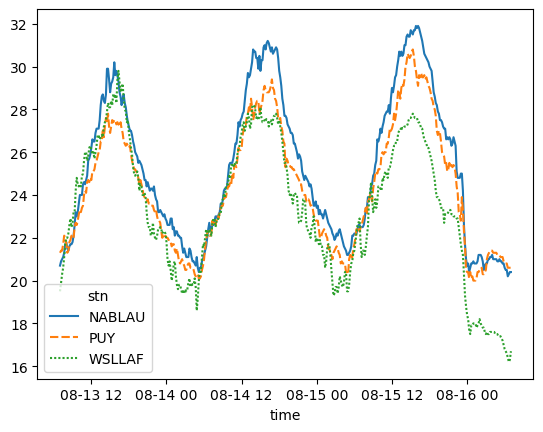

In [ ]:
sns.lineplot(data=idaweb_df)

#### VaudAir

In [ ]:
vaudair_df = client.get_vaudair_df(vaudair_key).loc[start_dt:end_dt]

<Axes: xlabel='time'>

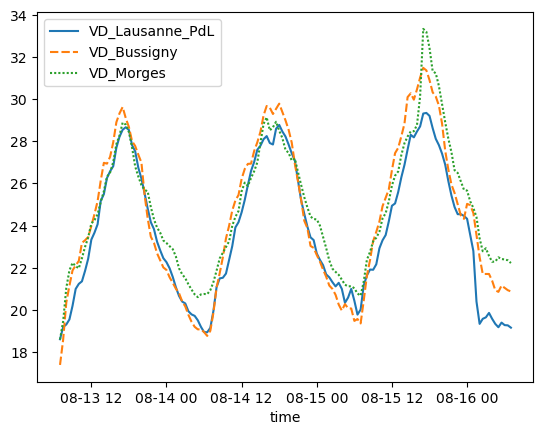

In [ ]:
sns.lineplot(data=vaudair_df)

### Agrometeo (public API)

In [ ]:
agrometeo_df = agrometeo.AgrometeoClient(region=agglom_extent_filepath).get_ts_df(
    variable="temperature", start_date=start_dt, end_date=end_dt
).loc[start_dt:end_dt]

<Axes: xlabel='time'>

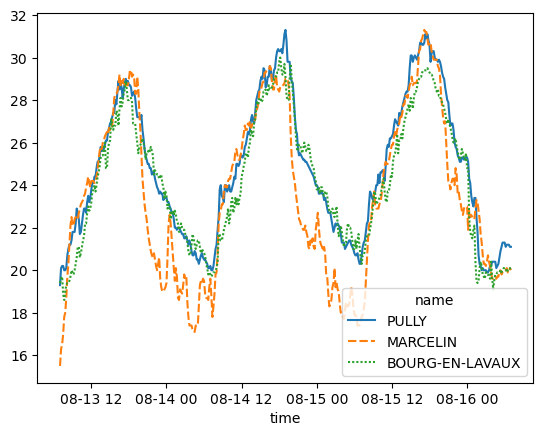

In [ ]:
sns.lineplot(data=agrometeo_df)

## Merge time series into a single dataframe

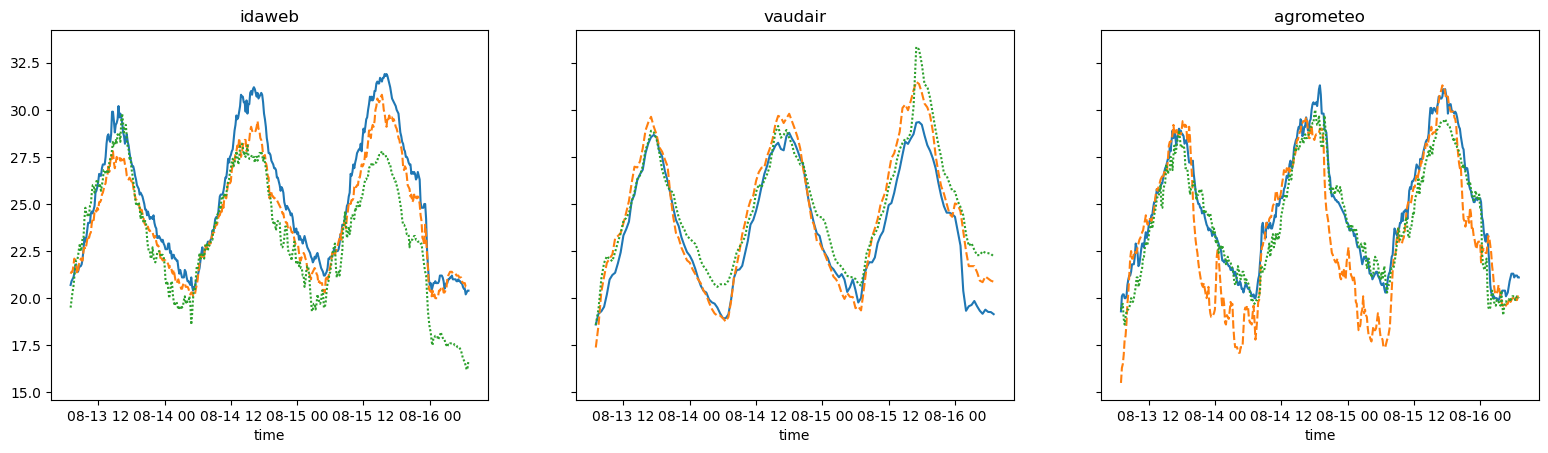

In [ ]:
df_dict = {"idaweb": idaweb_df, "vaudair": vaudair_df, "agrometeo": agrometeo_df}
n_cols = len(df_dict)
fig, axes = plt.subplots(
    1, n_cols, figsize=(n_cols * figwidth, figheight), sharey=True, sharex=True
)
for i, (name, df) in enumerate(df_dict.items()):
    sns.lineplot(data=df, ax=axes[i], legend=False)
    axes[i].set_title(name)

In [ ]:
ts_df = pd.concat(
    df_dict.values(),
    axis=1,
)

<Axes: xlabel='time'>

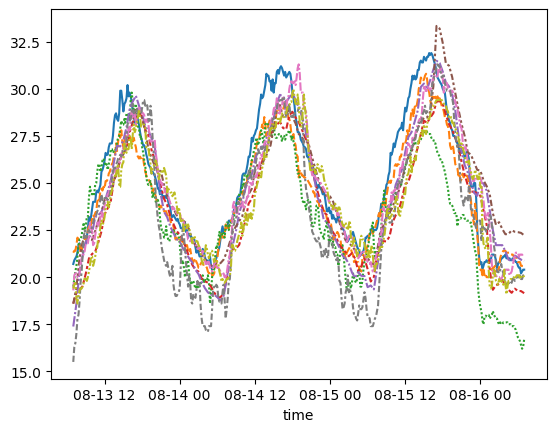

In [ ]:
sns.lineplot(data=ts_df, legend=False)

In [ ]:
# dump to file
ts_df.to_csv(dst_ts_df_filepath)

## Station locations

In [ ]:
station_gser = official_stations_utils.get_station_gser(
    station_location_filepath, station_location_crs
)

<Axes: >

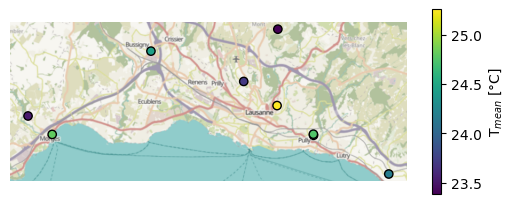

In [ ]:
# plot by average temperature
plot_kws = {"legend_kwds": {"shrink": 0.5, "label": "T$_{mean}$ [$\degree$C]"}}
plot_utils.plot_stations_by_var(station_gser, ts_df.mean().rename("T_mean"), plot_kws=plot_kws)

In [ ]:
# dump to file
station_gser.to_file(dst_station_gser_filepath)